# Decision Trees, Random Forest, and Gradient Boosting Trees

## Import and Prepare the Data

[pandas](https://pandas.pydata.org/) provides excellent data reading and querying module,[dataframe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), which allows you to import structured data and perform SQL-like queries. We also use the [mglearn](https://github.com/amueller/mglearn) package to help us visualize the data and models.

Here we imported some house price records from [Trulia](https://www.trulia.com/?cid=sem|google|tbw_br_nat_x_x_nat!53f9be4f|Trulia-Exact_352364665_22475209465_aud-278383240986:kwd-1967776155_260498918114_). For more about extracting data from Trulia, please check [my previous tutorial](https://www.youtube.com/watch?v=qB418v3k2vk).

We use the house type as the [dependent variable](https://en.wikipedia.org/wiki/Dependent_and_independent_variables) and the house ages and house prices as the [independent variables](https://en.wikipedia.org/wiki/Dependent_and_independent_variables).

To visualize the trees, we use the [graphviz](https://pypi.org/project/graphviz/) python module. You also need to download  the [graphviz Executable Package](https://www.graphviz.org/download/) on your computer.

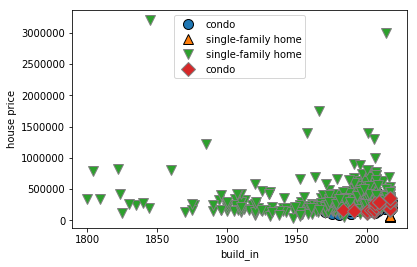

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
import pandas
import numpy as np
import mglearn
from collections import Counter
from sklearn.metrics import cohen_kappa_score

import graphviz   # use graphviz to visualize trees
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\Graphviz2.38\bin" # link to the graphviz executable package 

df = pandas.read_excel('house_price_label.xlsx')
# combine multipl columns into a 2D array
# also convert the integer data to float data
X = np.column_stack((df.built_in.astype(float),df.price.astype(float))) 
y = df.house_type
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3,stratify = y, random_state=0) 

# for classification, make sure a stratify splitting method is selected
mglearn.discrete_scatter(X[:,0],X[:,1],y) # use mglearn to visualize data

plt.legend(y,loc='best')
plt.xlabel('build_in')
plt.ylabel('house price')
plt.show()

## Decision Trees

A decision tree uses a tree structure to represent many possible decision paths and an outcome for each path. To build a tree, the algorithm searches over all possible questions or splits and finds the one that is most informative about the target variable. The quality of a question or split is measured with [Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning) or the [Information Gain](https://en.wikipedia.org/wiki/Decision_tree_learning) which based on [Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory).

Here we use [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to classify the house types based on house ages and house prices. 

In [2]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Training set accuracy: {:.2f}".format(tree.score(X_train, y_train)))
print ("Training Kappa: {:.3f}".format(cohen_kappa_score(y_train,tree.predict(X_train))))
print("Test set accuracy: {:.2f}".format(tree.score(X_test, y_test)))
print ("Test Kappa: {:.3f}".format(cohen_kappa_score(y_test,tree.predict(X_test))))



Training set accuracy: 0.99
Training Kappa: 0.982
Test set accuracy: 0.87
Test Kappa: 0.631


It is very easy (and very bad) to build decision trees that are overfitted to the training data, and that doesn’t generalize well to unseen data. We can control the complexity of the tree by limit [the maximum depth of the tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) or [the maximum number of leaves](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), and [more](http://scikit-learn.org/stable/modules/tree.html#tree).

In [3]:
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)

print("Training set accuracy: {:.2f}".format(tree.score(X_train, y_train)))
print ("Training Kappa: {:.3f}".format(cohen_kappa_score(y_train,tree.predict(X_train))))
print("Test set accuracy: {:.2f}".format(tree.score(X_test, y_test)))
print ("Test Kappa: {:.3f}".format(cohen_kappa_score(y_test,tree.predict(X_test))))



Training set accuracy: 0.88
Training Kappa: 0.639
Test set accuracy: 0.81
Test Kappa: 0.410


We can visualize and analyze the tree using the [graphviz](https://www.graphviz.org/) module.

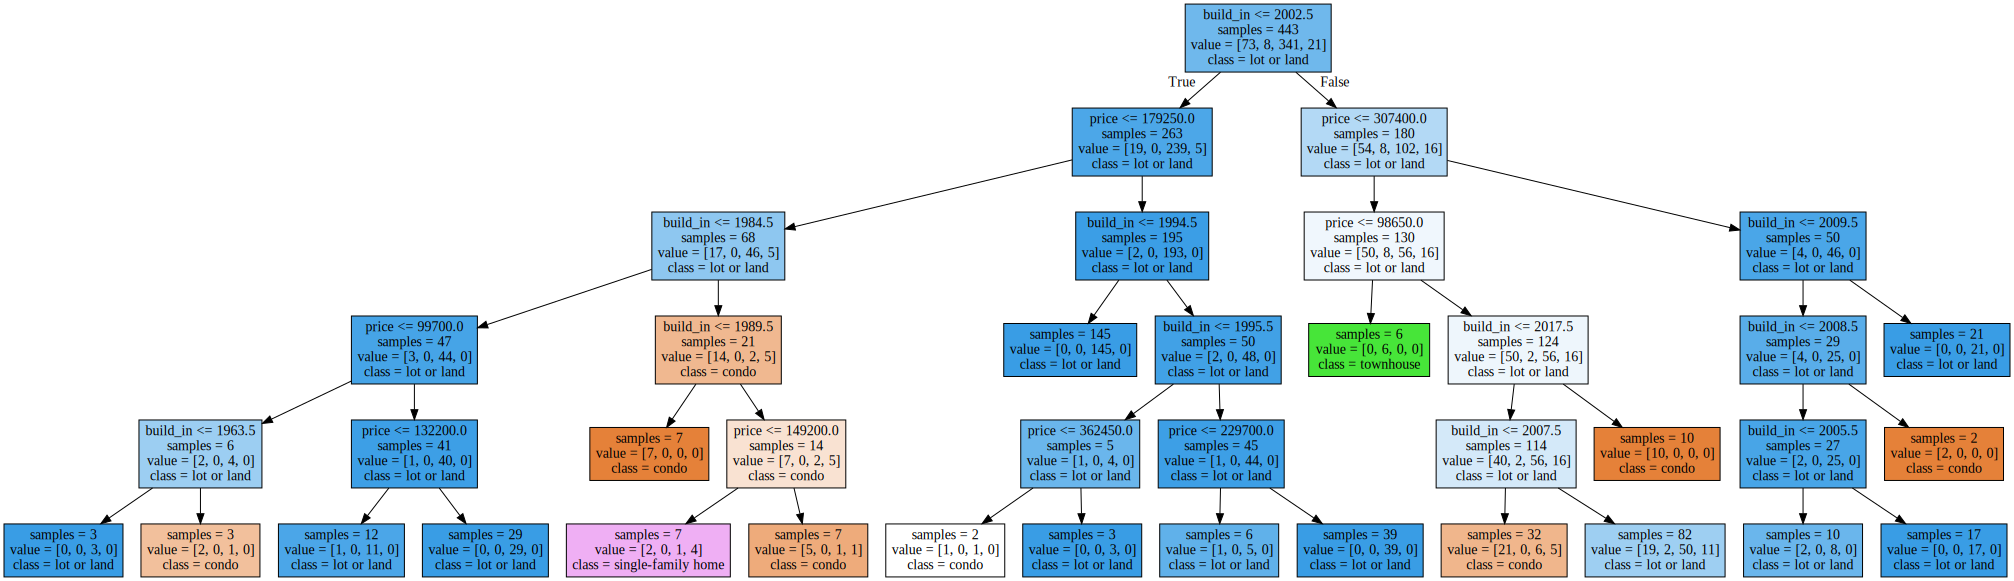

In [4]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", impurity=False, filled=True,
                feature_names = ['build_in','price'],class_names= list(set(y)))

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph )


## Random Forest

Given how closely decision trees can fit themselves to their training data, it’s not surprising that decision trees tend to overfit. One way of avoiding this is a technique called [Random Forest](https://en.wikipedia.org/wiki/Random_forest), in which we build multiple decision trees and let them vote on how to classify inputs.

Here we use [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify the house types based on house ages and house prices. 

In [5]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(X_train, y_train)

print("Training set accuracy: {:.2f}".format(forest.score(X_train, y_train)))
print ("Training Kappa: {:.3f}".format(cohen_kappa_score(y_train,forest.predict(X_train))))
print("Test set accuracy: {:.2f}".format(forest.score(X_test, y_test)))
print ("Test Kappa: {:.3f}".format(cohen_kappa_score(y_test,forest.predict(X_test))))

Training set accuracy: 0.97
Training Kappa: 0.909
Test set accuracy: 0.85
Test Kappa: 0.596


If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results. This reduction in overfitting, while retaining the predictive power of the trees, can be shown in the following charts.

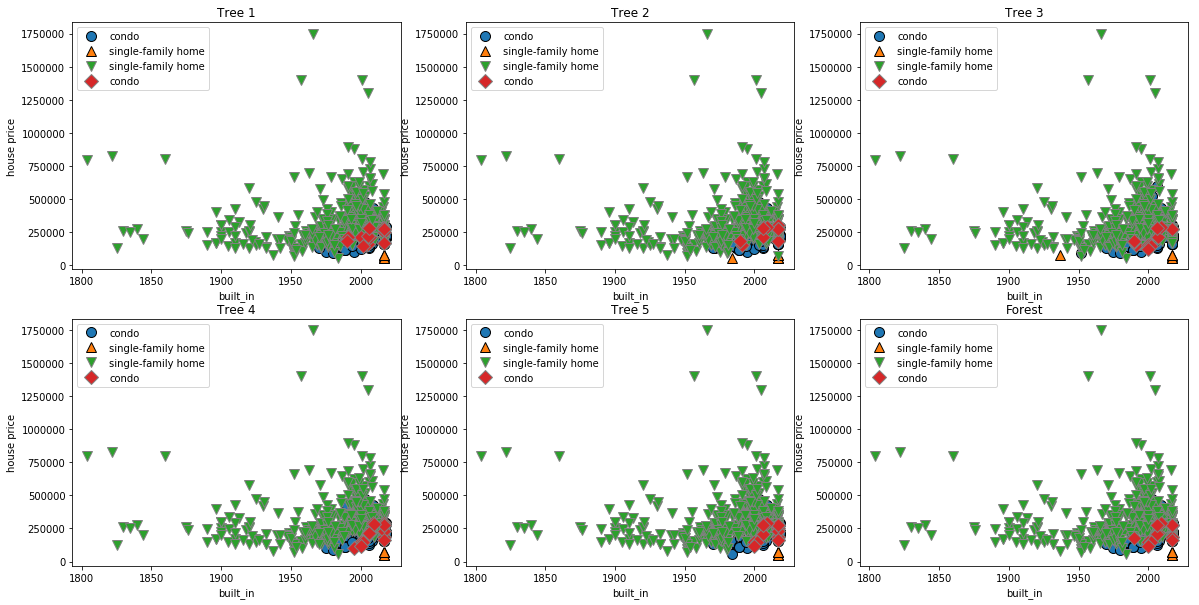

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i<5:
        sub_tree = forest.estimators_[i]
        ax.set_title("Tree {}".format(i+1))
        mglearn.discrete_scatter(X_train[:,0],X_train[:,1],sub_tree.predict(X_train),ax=ax) # use mglearn to visualize data

    else:
        ax.set_title("Forest")
    
        mglearn.discrete_scatter(X_train[:,0],X_train[:,1],forest.predict(X_train),ax=ax) # use mglearn to visualize data

    ax.set_xlabel("built_in")
    ax.set_ylabel("house price")
    ax.legend(y,loc='best')


## Gradient Boosting Trees

[Gradient Boosting Tree](https://en.wikipedia.org/wiki/Gradient_boosting) works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one.

Here we use [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to classify the house types based on house ages and house prices. 

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Training set accuracy: {:.2f}".format(gbrt.score(X_train, y_train)))
print ("Training Kappa: {:.3f}".format(cohen_kappa_score(y_train,gbrt.predict(X_train))))
print("Test set accuracy: {:.2f}".format(gbrt.score(X_test, y_test)))
print ("Test Kappa: {:.3f}".format(cohen_kappa_score(y_test,gbrt.predict(X_test))))

Training set accuracy: 0.98
Training Kappa: 0.933
Test set accuracy: 0.86
Test Kappa: 0.608


In the Gradient Boosting Trees, we can also control the [max depth](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) and the [learning rate](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) to reduce or increase the model complexity. 

In [8]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Training set accuracy: {:.2f}".format(gbrt.score(X_train, y_train)))
print ("Training Kappa: {:.3f}".format(cohen_kappa_score(y_train,gbrt.predict(X_train))))
print("Test set accuracy: {:.2f}".format(gbrt.score(X_test, y_test)))
print ("Test Kappa: {:.3f}".format(cohen_kappa_score(y_test,gbrt.predict(X_test))))

Training set accuracy: 0.85
Training Kappa: 0.509
Test set accuracy: 0.83
Test Kappa: 0.433


In [9]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Training set accuracy: {:.2f}".format(gbrt.score(X_train, y_train)))
print ("Training Kappa: {:.3f}".format(cohen_kappa_score(y_train,gbrt.predict(X_train))))
print("Test set accuracy: {:.2f}".format(gbrt.score(X_test, y_test)))
print ("Test Kappa: {:.3f}".format(cohen_kappa_score(y_test,gbrt.predict(X_test))))

Training set accuracy: 0.88
Training Kappa: 0.612
Test set accuracy: 0.85
Test Kappa: 0.505


## Summary

1. All the above three models can be used for classification and regression, such as [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor), [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor), and [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)
2. All the above three models can be used for classification and regression, such as DecisionTreeRegressor, RandomForestRegressor, and GradientBoostingRegressor
3. All the three models don't work well with high dimensional and sparse data, such as text data.
4. Decision Trees tend to overfit the training data, but easy to understand.
5. Random Forests and Gradient Boosted Trees are two widely used and most powerful machine learning models. 

    5.1  Random Forests overcomes the overfitting problem of the Decision Trees and provides a much more intuitive decision boundary.
    
    5.2 Gradient Bosted Trees requires careful tuning of the parameters and may overfit the training data. In addition to sklearn, [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) also provides a parallel tree boosting solution in Python.


